<a href="https://colab.research.google.com/github/pavelpryadokhin/Data-Scientist/blob/main/Hotel_Predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Исследуем датасет бронирования гостиниц, с целью научиться прогнозировать вероятность отмены брони. И визуализируем это все в Gradio interface. [Ссылка на датасет](https://www.kaggle.com/datasets/ahsan81/hotel-reservations-classification-dataset)


#Предобработка данных

In [ ]:
!pip install gradio

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
# import gradio as gr
import datetime

In [ ]:
df = pd.read_csv('/content/Hotel Reservations.csv')
df.head()

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled


Добавим столбец на какой день недели бронируется гостиница. Так как есть некорретные данные (в 2018 году 28 дней, а не 29) исправляем их

In [ ]:
df.loc[(df['arrival_year'] == 2018) & (df['arrival_month'] == 2) & (df['arrival_date'] == 29), 'arrival_date'] = 28

In [ ]:
df['day_of_week']=pd.to_datetime(df[['arrival_year', 'arrival_month', 'arrival_date']].astype(str).agg('-'.join, axis=1))
df['day_of_week']=df['day_of_week'].dt.dayofweek

Удаляем лишние столбцы: ID, год, месяц, день.

In [ ]:
df=df.drop(columns=['Booking_ID','arrival_year','arrival_month','arrival_date'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 16 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   no_of_adults                          36275 non-null  int64  
 1   no_of_children                        36275 non-null  int64  
 2   no_of_weekend_nights                  36275 non-null  int64  
 3   no_of_week_nights                     36275 non-null  int64  
 4   type_of_meal_plan                     36275 non-null  object 
 5   required_car_parking_space            36275 non-null  int64  
 6   room_type_reserved                    36275 non-null  object 
 7   lead_time                             36275 non-null  int64  
 8   market_segment_type                   36275 non-null  object 
 9   repeated_guest                        36275 non-null  int64  
 10  no_of_previous_cancellations          36275 non-null  int64  
 11  no_of_previous_

In [ ]:
df.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status,day_of_week
0,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,Offline,0,0,0,65.00,0,Not_Canceled,0
1,2,0,2,3,Not Selected,0,Room_Type 1,5,Online,0,0,0,106.68,1,Not_Canceled,1
2,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,Online,0,0,0,60.00,0,Canceled,2
3,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,Online,0,0,0,100.00,0,Canceled,6
4,2,0,1,1,Not Selected,0,Room_Type 1,48,Online,0,0,0,94.50,0,Canceled,2


Преобразуем столбцы типа object в числовой тип.

In [ ]:
def encode(df,val):
  le = LabelEncoder()
  df[val]=le.fit_transform(df[val])
  return dict(zip(le.classes_, le.transform(le.classes_)))

replace_dict = {}
data=['type_of_meal_plan','room_type_reserved','market_segment_type','booking_status']
for column in data:
  replace_dict[column] = encode(df,column)

In [ ]:
df.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status,day_of_week
0,2,0,1,2,0,0,0,224,3,0,0,0,65.00,0,1,0
1,2,0,2,3,3,0,0,5,4,0,0,0,106.68,1,1,1
2,1,0,2,1,0,0,0,1,4,0,0,0,60.00,0,0,2
3,2,0,0,2,0,0,0,211,4,0,0,0,100.00,0,0,6
4,2,0,1,1,3,0,0,48,4,0,0,0,94.50,0,0,2


Проверим, есть ли незаполненные строки.

In [ ]:
df.isnull().sum()

,0
no_of_adults,0
no_of_children,0
no_of_weekend_nights,0
no_of_week_nights,0
type_of_meal_plan,0
required_car_parking_space,0
room_type_reserved,0
lead_time,0
market_segment_type,0
repeated_guest,0


Создадим копию датасета для анализа данных

In [ ]:
analysis_df=df.copy()
analysis_df['all_nights'] = analysis_df['no_of_weekend_nights'] + analysis_df['no_of_week_nights']
analysis_df['all_person']=analysis_df['no_of_adults']+analysis_df['no_of_children']


Рассмотрим существующие связи, как видим распределение данных удовлетворяет нормальному закону распределения (кроме взаимосвязанных данных, например как количество человек и цена;дни рабочие и выходные)

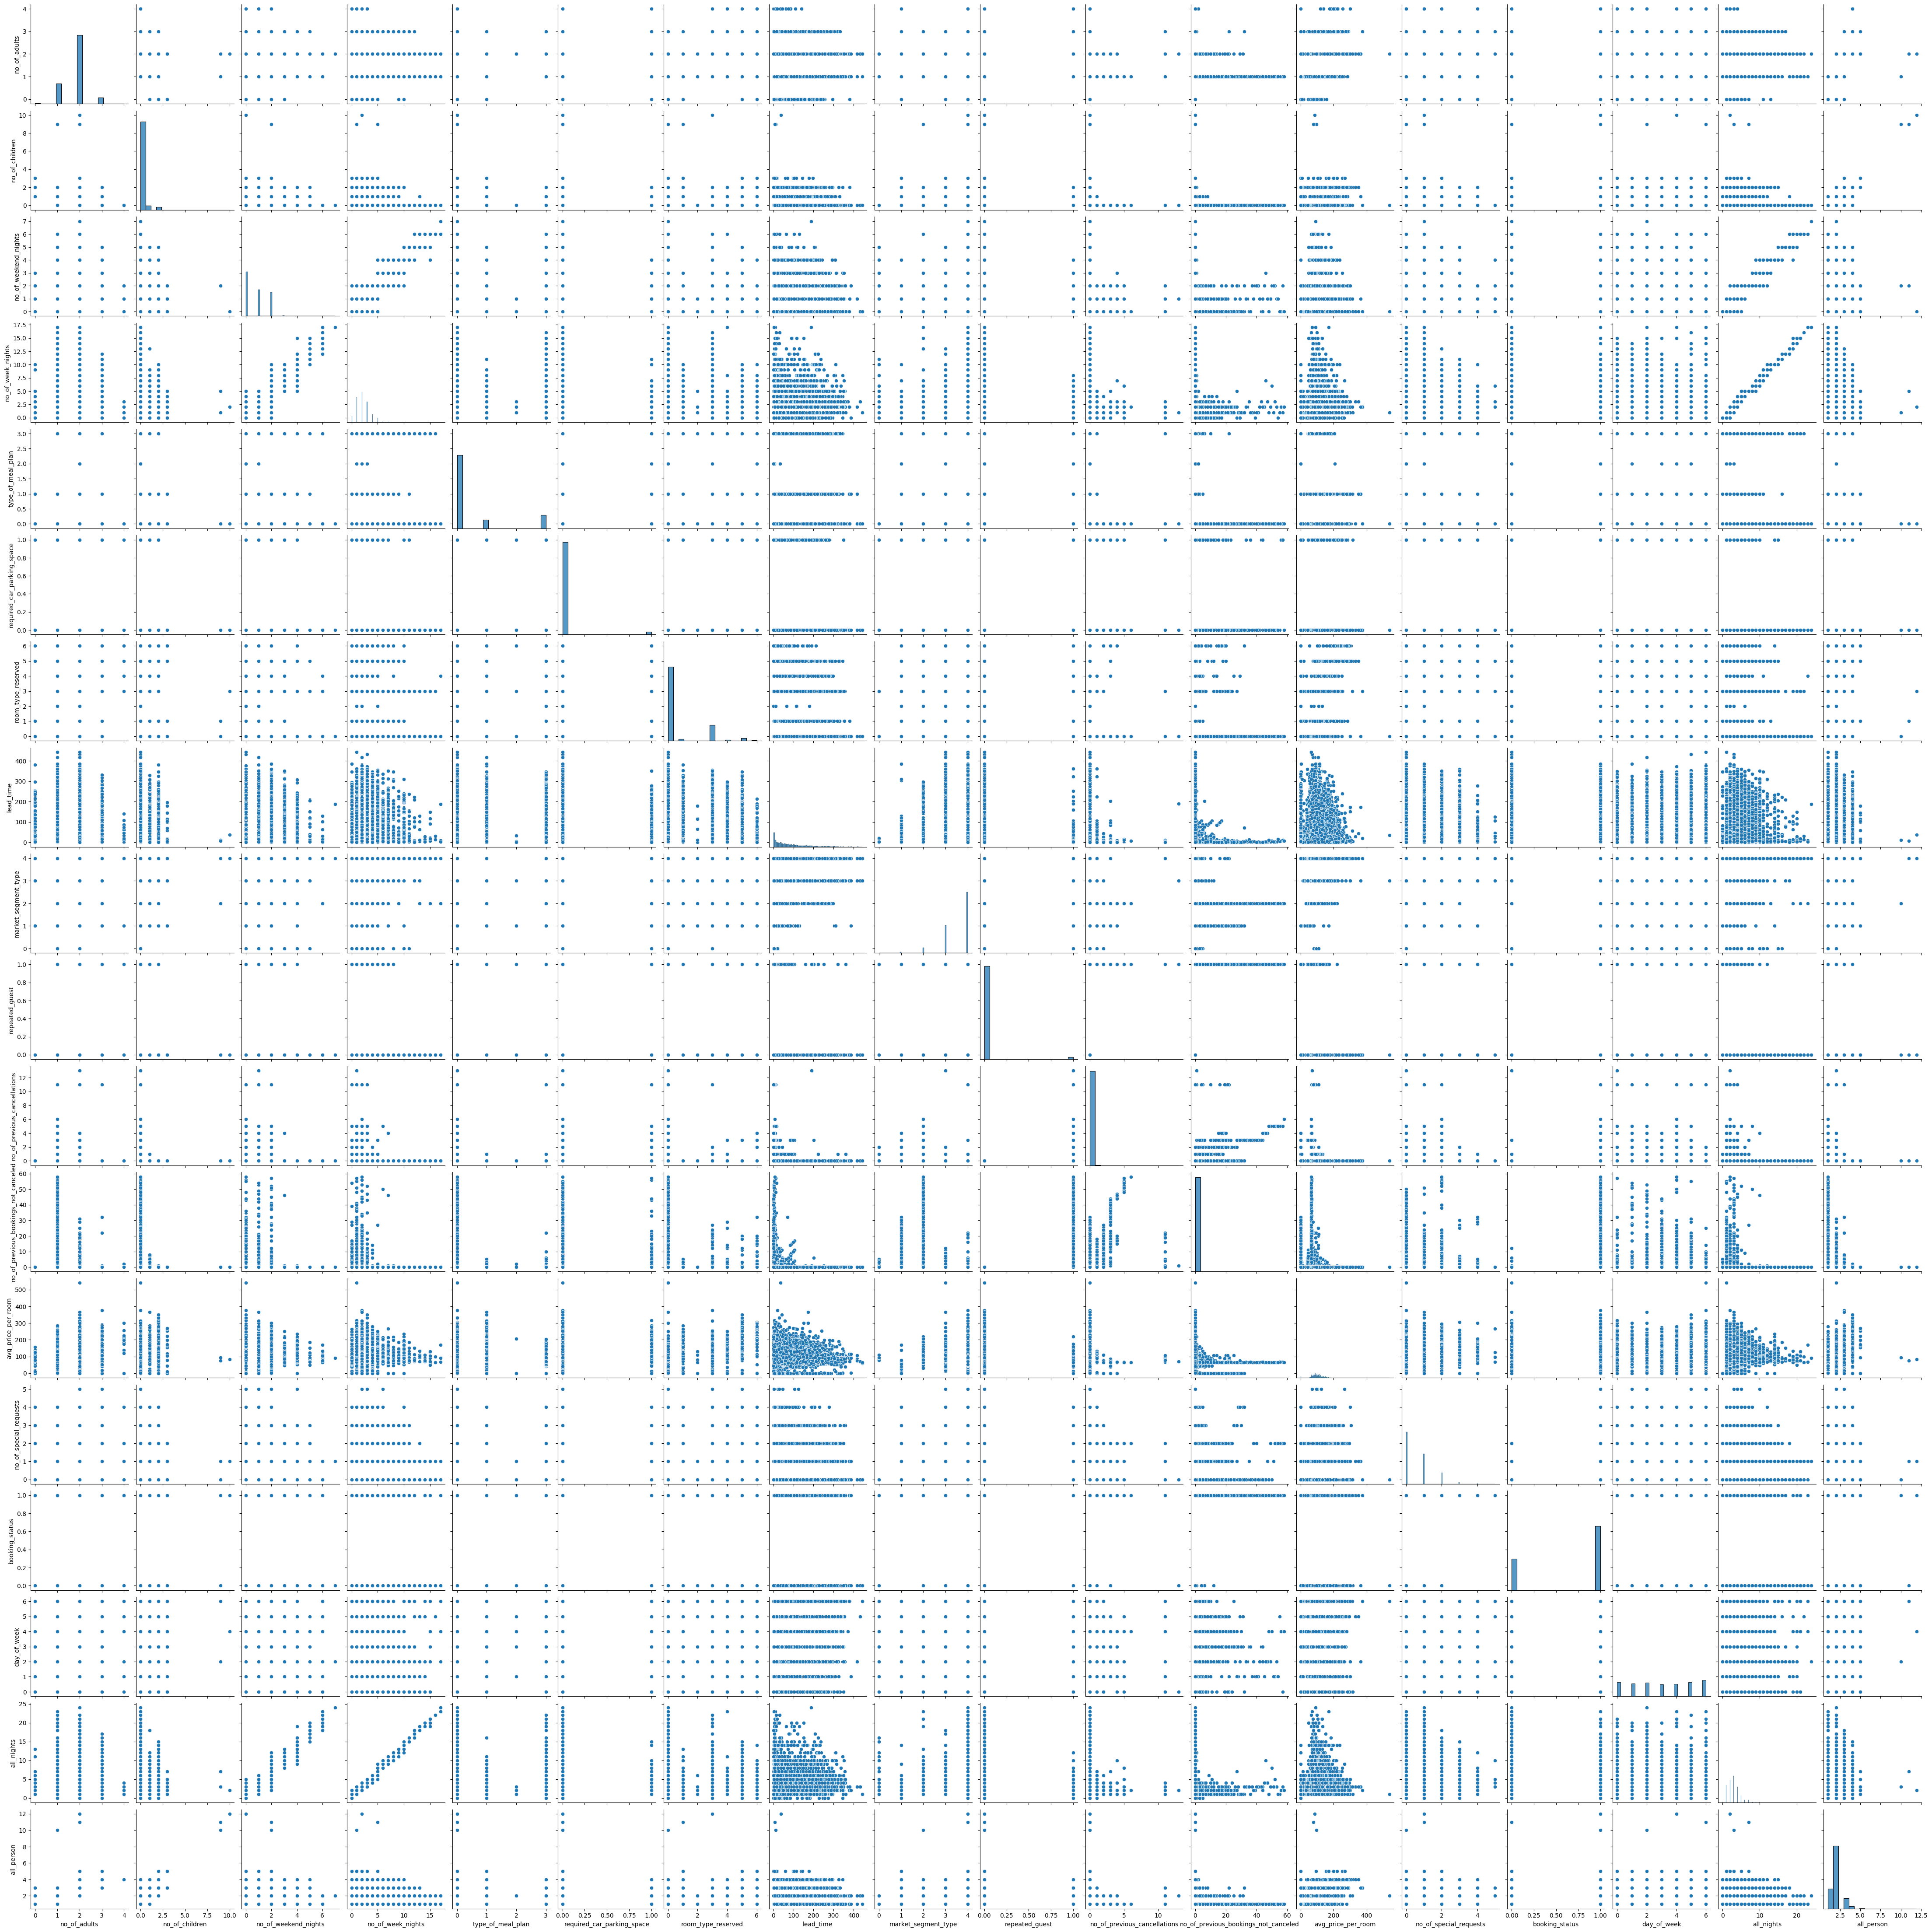

In [ ]:
sns.pairplot(data=analysis_df[:])
plt.show()

Также рассмотрим матрицу корреляции

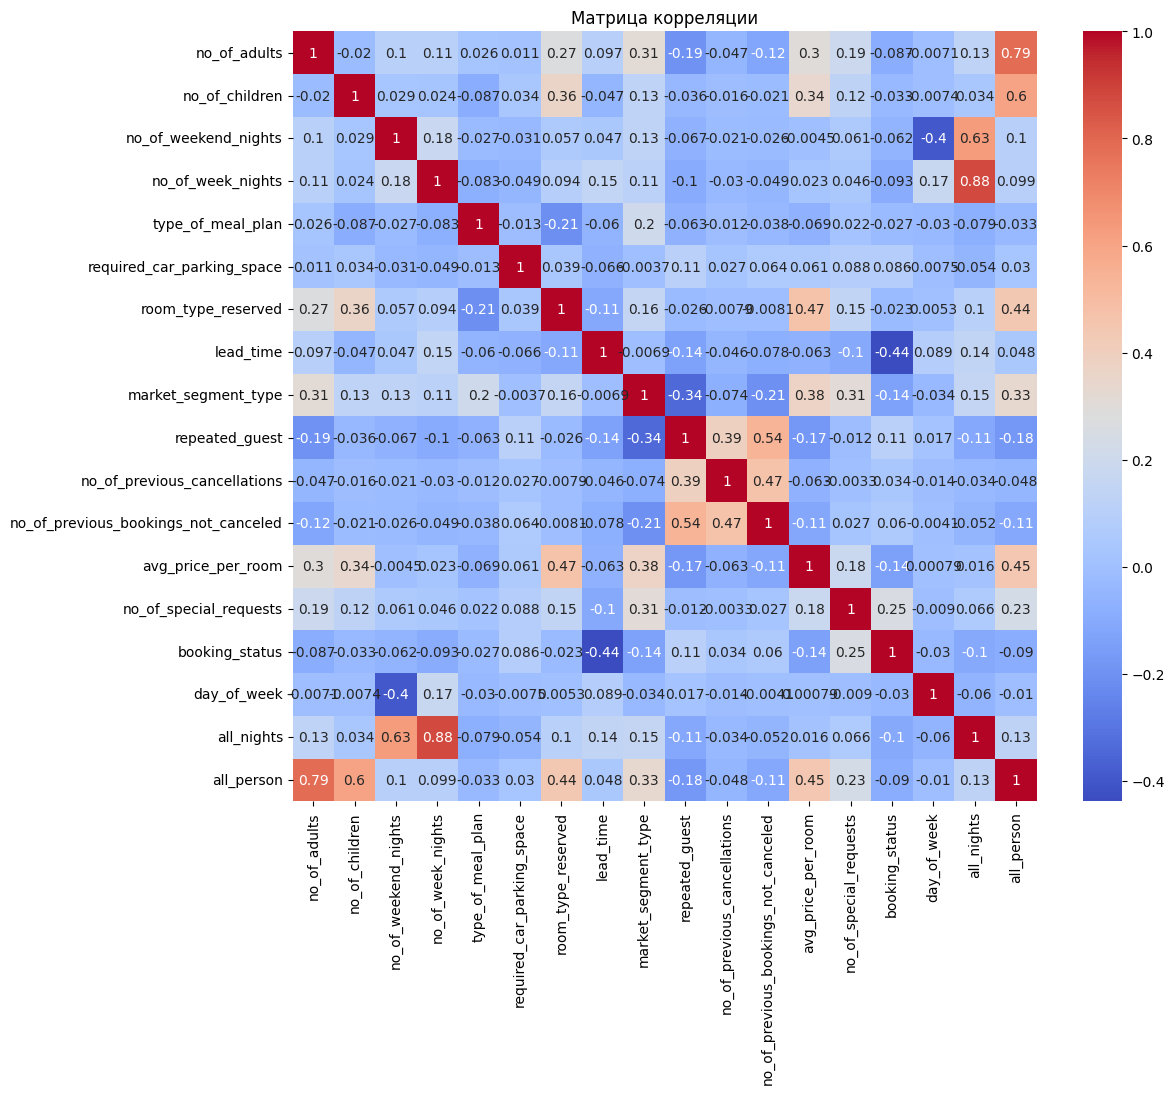

In [ ]:
plt.figure(figsize=(12, 10))
correlation_matrix = analysis_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Матрица корреляции')
plt.show()

Рассмотрим количество распределений бронь и отмена. Видим, что данных в которых забронировали болше почти в два раза.

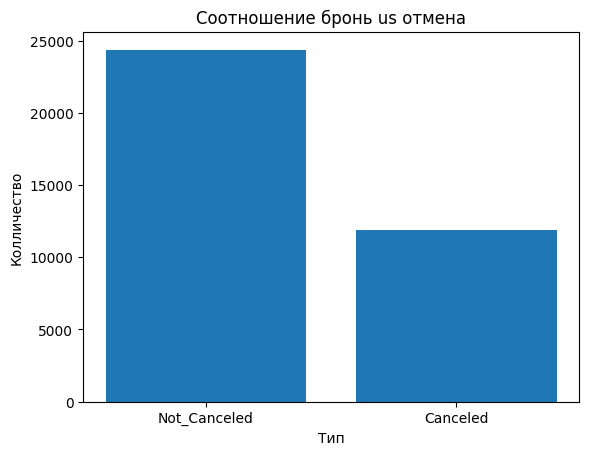

In [ ]:
plt.bar(['Not_Canceled', 'Canceled'], analysis_df.booking_status.value_counts())
plt.xlabel('Тип')
plt.ylabel('Колличество')
plt.title("Соотношение бронь us отмена");

Рассмотрим количество бронирований с различным статусом по дням.

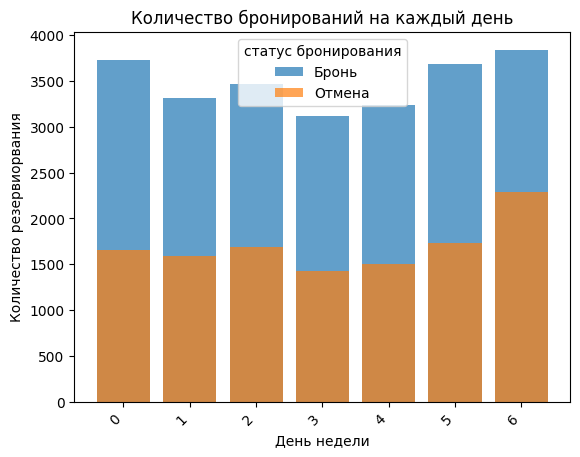

In [ ]:
data_grouped = analysis_df.groupby(['booking_status', 'day_of_week']).size().unstack()
fig, ax = plt.subplots()

for status in analysis_df['booking_status'].unique():
    ax.bar(data_grouped.columns, data_grouped.loc[status], label=status, alpha=0.7)

ax.set_title('Количество бронирований на каждый день')
ax.set_xlabel('День недели')
ax.set_ylabel('Количество резервиорвания')
ax.legend(['Бронь', 'Отмена'],title='статус бронирования')
plt.xticks(rotation=45, ha='right')
plt.show()

Расределение цен соответсвует нормальному закону распределения с средним  значением около 100 евра.

<Figure size 800x600 with 0 Axes>

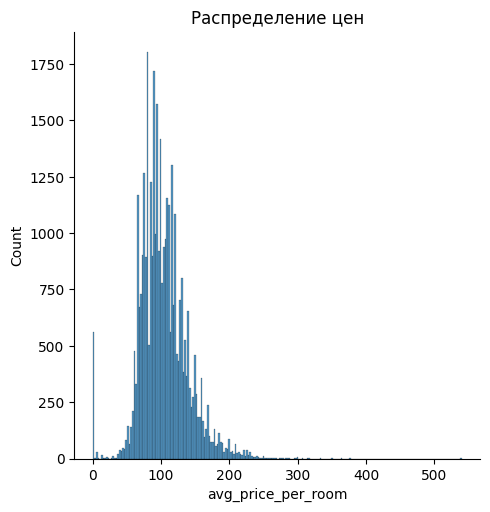

In [ ]:
plt.figure(figsize=(8, 6))
sns.displot(x='avg_price_per_room', data=analysis_df)
plt.title('Распределение цен')
plt.show()

Добавим для лучшего прогнозирования общее количество ночей.

In [ ]:
df['all_nights'] = df['no_of_weekend_nights'] + df['no_of_week_nights']

In [ ]:
x = df.drop(columns=['booking_status'])
y = df['booking_status']

In [ ]:
print(x[y==0].shape)
print(x[y==1].shape)

(11885, 16)
(24390, 16)


In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=1000)
x_, y_ = smote.fit_resample(x, y)

print(x_[y_==0].shape)
print(x_[y_==1].shape)

(24390, 16)
(24390, 16)


#Постобработка данных

Обучающей выборки 80%, тестовой - 20%. Проанализируем различные методы машинного обучения и выберем лучший

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x_, y_, test_size=0.2, random_state=7, stratify=y_)


#Выбор метода

##Метод опорных векторов

In [ ]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf', random_state=0, gamma=.10, C=1.0)
svm.fit(X_train, y_train)

SVC(gamma=0.1, random_state=0)

##Алгоритм машинного обучения XGBoost

In [ ]:
import xgboost as xgb

xgb_clf = xgb.XGBClassifier()
xgb_clf = xgb_clf.fit(X_train, y_train)

##Метод k-ближайших соседей

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
knn.fit(X_train, y_train)

KNeighborsClassifier()

##Дерево решений

In [ ]:
from sklearn import tree

decision_tree = tree.DecisionTreeClassifier(criterion='gini')
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier()

##Случайный лес

In [ ]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(n_estimators=115,random_state=7)
random_forest.fit(X_train, y_train)

RandomForestClassifier(n_estimators=115, random_state=7)

##Логистическая регрессия

In [ ]:
from sklearn.linear_model import LogisticRegression

lg = LogisticRegression(solver='lbfgs')
lg.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

##Наивный байесовский классификатор

In [ ]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train , y_train)

GaussianNB()

#Анализ методов

Как видим, лучше всего справляется случайный лес с  точностью на тестовой выборки 89.4%. Также достаточно хорошо прогнозируют XGBoost(88.27%) и дерево решений (85.84%). Не справляется с работоймодель наивный байесовский классификатор(39.53%)

In [ ]:
def unleash_accuracy_of_classifiers():
    test_models = [svm, xgb_clf, knn, decision_tree, random_forest, lg, nb]
    # test_models = [ xgb_clf, knn, decision_tree, random_forest, lg, nb]

    names_models = ['SVM', 'XGBoost', 'KNN', 'Decision Tree', 'Random Forest', 'Logistic Regression', 'GaussianNB']
    # names_models = ['XGBoost', 'KNN', 'Decision Tree', 'Random Forest', 'Logistic Regression', 'GaussianNB']

    for model, name in zip(test_models, names_models):
        train_accuracy = model.score(X_train, y_train) * 100
        test_accuracy = model.score(X_test, y_test) * 100

        print(f'The accuracy of {name} on training data is: {train_accuracy:.2f}')
        print(f'The accuracy of {name} on test data is: {test_accuracy:.2f}')
        print('\n' + '+' * 40 + '\n')

# Unleash the function to witness the power of classifiers
unleash_accuracy_of_classifiers()

The accuracy of SVM on training data is: 96.27
The accuracy of SVM on test data is: 88.29

++++++++++++++++++++++++++++++++++++++++

The accuracy of XGBoost on training data is: 91.32
The accuracy of XGBoost on test data is: 88.93

++++++++++++++++++++++++++++++++++++++++

The accuracy of KNN on training data is: 89.55
The accuracy of KNN on test data is: 83.61

++++++++++++++++++++++++++++++++++++++++

The accuracy of Decision Tree on training data is: 99.39
The accuracy of Decision Tree on test data is: 88.40

++++++++++++++++++++++++++++++++++++++++

The accuracy of Random Forest on training data is: 99.39
The accuracy of Random Forest on test data is: 90.99

++++++++++++++++++++++++++++++++++++++++

The accuracy of Logistic Regression on training data is: 76.87
The accuracy of Logistic Regression on test data is: 76.94

++++++++++++++++++++++++++++++++++++++++

The accuracy of GaussianNB on training data is: 55.29
The accuracy of GaussianNB on test data is: 55.26

+++++++++++++++++

#Визуализация в Gradio interface

Визуализируем все в Gradio interface

In [ ]:
def predict(no_of_adults, no_of_children, no_of_weekend_nights, no_of_week_nights,
            type_of_meal_plan, required_car_parking_space, room_type_reserved,
            lead_time, market_segment_type,arrival_year,arrival_month,arrival_date,
            repeated_guest, no_of_previous_cancellations, no_of_previous_bookings_not_canceled,
            avg_price_per_room, no_of_special_requests ):
  new_df = pd.DataFrame({
      'no_of_adults':[no_of_adults],
      'no_of_children':[no_of_children],
      'no_of_weekend_nights':[no_of_weekend_nights],
      'no_of_week_nights':[no_of_week_nights],
      'type_of_meal_plan':[replace_dict['type_of_meal_plan'][type_of_meal_plan]],
      'required_car_parking_space':[required_car_parking_space],
      'room_type_reserved':[replace_dict['room_type_reserved'][room_type_reserved]],
      'lead_time':[lead_time],
      'market_segment_type':[replace_dict['market_segment_type'][market_segment_type]],
      'repeated_guest':[repeated_guest],
      'no_of_previous_cancellations':[no_of_previous_cancellations],
      'no_of_previous_bookings_not_canceled':[no_of_previous_bookings_not_canceled],
      'avg_price_per_room':[avg_price_per_room],
      'no_of_special_requests':[no_of_special_requests],
      'day_of_week':[datetime.datetime(arrival_year,arrival_month,arrival_date,).weekday()],
      'all_nights':[int(no_of_weekend_nights) + int(no_of_week_nights)]
  })
  prediction = random_forest.predict(new_df)[0]
  return 'Not_Canceled'	if prediction else 'Canceled'


In [ ]:
inputs = [
    gr.Number(label="Number of Adults"),
    gr.Number(label="Number of Children"),
    gr.Number(label="Number of Weekend Nights"),
    gr.Number(label="Number of Week Nights"),
    gr.Dropdown(label="Type of Meal Plan", choices=replace_dict['type_of_meal_plan'].keys()),
    gr.Number(label="Required Car Parking Space"),
    gr.Dropdown(label="Room Type Reserved", choices=replace_dict['room_type_reserved'].keys()),
    gr.Number(label="Lead Time"),
    gr.Dropdown(label="Market Segment Type", choices=replace_dict['market_segment_type'].keys()),
    gr.Number(label="Arrival Year"),
    gr.Number(label="Arrival Month"),
    gr.Number(label="Arrival Date"),
    gr.Dropdown(label="Repeated Guest", choices=['0','1']),
    gr.Number(label="Number of Previous Cancellations"),
    gr.Number(label="Number of Previous Bookings Not Canceled"),
    gr.Number(label="Average Price Per Room"),
    gr.Number(label="Number of Special Requests"),
]

outputs = gr.Textbox(label="Prediction")

iface = gr.Interface(fn=predict,
                     inputs=inputs,
                     outputs=outputs,
                     title="Hotel Booking Cancellation Prediction")
iface.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://8c332e075fa3770b97.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Пример работы

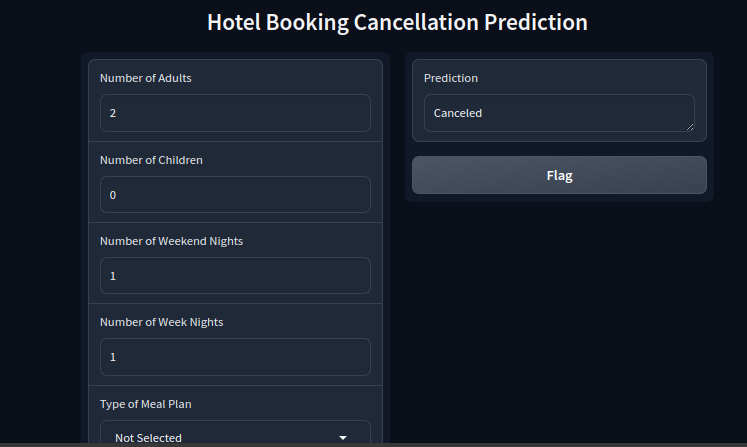

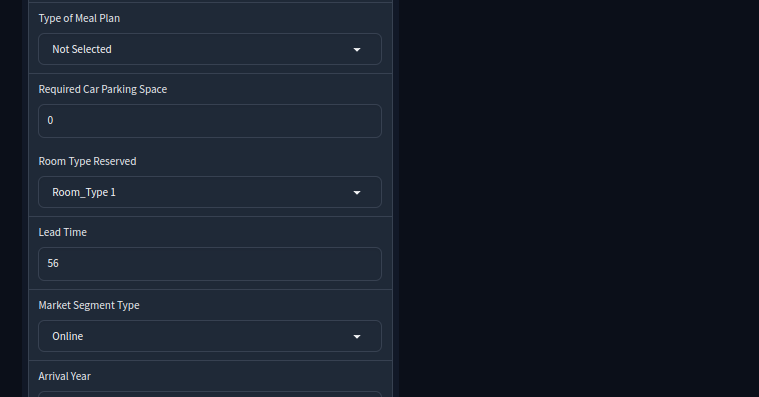

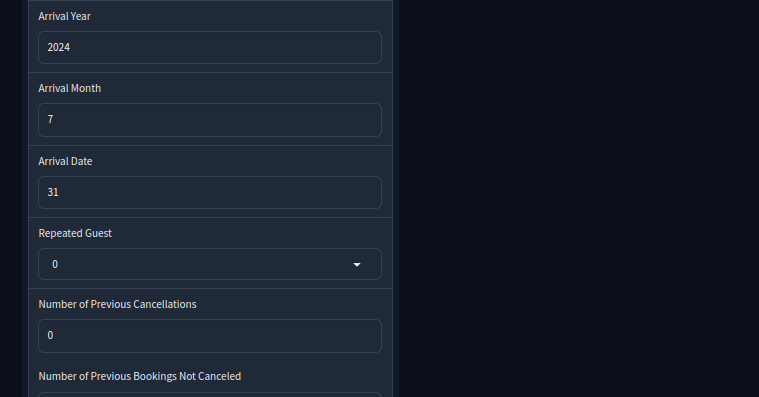

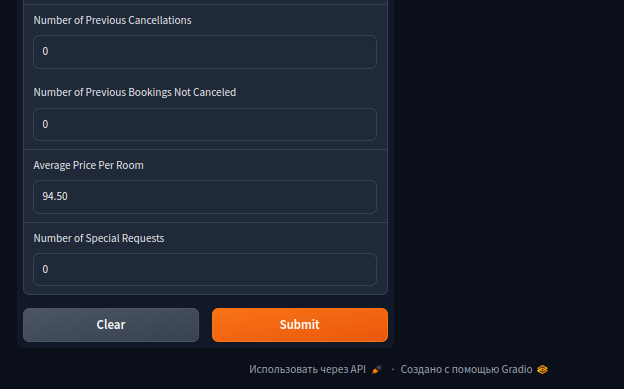